## cloudFPGA Studio
### Case study: Harris Corner Detector (Computer Vision) - NumpPy version
### You don't need FPGA knowledge, just basic Python syntax !!!

Note: Assuming that the FPGA is already flashed

Configure the Python path to look for FPGA aceleration library

In [1]:
import time
import sys
import os
from IPython.display import Image
from IPython.display import display

# for software execution
import cv2 as cv
import numpy as np
import argparse
from matplotlib import pyplot as plt

In [2]:
trieres_lib=os.environ['cFpRootDir'] + "HOST/vision/harris/languages/python/build"
sys.path.append(trieres_lib)

Import the FPGA accelerator library

In [3]:
import _trieres_harris_numpi

Assign the IP of the FPGA that is already loaded with Harris image

In [4]:
# Give image dimensions (the ones that the FPGA bitstream is configured with!) 
height = width = 256

#fpga_ip=os.environ['FPGA_IP']
fpga_ip="localhost"
print(fpga_ip)

localhost


INFO: Give either an input image for processing or skip the next cell and select an image from your camera:

In [5]:
# Give an input image (any size - it will be resized if it's not equal to the ones before)
image_in_filename = os.environ['cFpRootDir'] + "ROLE/vision/hls/harris/test/512x512.png"
image_out_filename = image_in_filename + "_fpga_points_out_frame_1.png"
Image(filename = image_in_filename, width = width, height = height)

# Reading an image in unchanged mode 
image = cv.imread(image_in_filename, cv.IMREAD_UNCHANGED) 

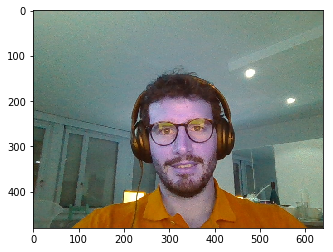

In [13]:
# Give an input image from your camera (any size - it will be resized if it's not equal to the ones before)

# Assign some filenames for images
image_in_filename = os.environ['cFpRootDir'] + "ROLE/vision/hls/harris/test/cam.png"
image_out_filename = image_in_filename + "_fpga_points_out_frame_1.png"

cap = cv.VideoCapture(0)
if cap.isOpened():
    ret, image = cap.read()
    # Convert the image from OpenCV BGR format to matplotlib RGB format to display the image
    #frame = cv.cvtColor(frame, cv.COLOR_BGR2RGB)
    cap.release()
    cv.imwrite(image_in_filename, image)
    plt.imshow(image)
    plt.show()
else:
    print("Error: cannot capture a frame from camera")

In [14]:
# Converting to grayscale
image = cv.cvtColor(image, cv.COLOR_RGB2GRAY)

# Adjusting the image file if needed
if ((image.shape[0] != height) or (image.shape[1] != width)):
  print("Warning: The image was resized from [", image.shape[0] , " x ", image.shape[1] , "] to [", height  , " x ", width, "]")
  dim = (width, height) 
  image = cv.resize(image, dim, interpolation = cv.INTER_LINEAR) 

# Flattening the image from 2D to 1D
image = image.flatten()

In [49]:
def cornerHarris_hw(image):
    # Detecting corners
    start_fpga = time.time()
    dst1d = _trieres_harris_numpi.harris(image, height*width, fpga_ip, "1234")
    elapsed_fpga =  time.time() - start_fpga
    # Convert 1D array to a 2D numpy array of 2 rows and 3 columns
    dst = np.reshape(dst1d, (height, width))
    cv.imwrite(image_out_filename, dst)
    print("INFO: the output file is saved at : " + image_out_filename)
    return elapsed_fpga

Execute the FPGA accelerator as a Python function

In [50]:
elapsed_fpga = cornerHarris_hw(image)

INFO: the output file is saved at : /home/diaman/projects/cloudFPGA/cFp_Vitis/ROLE/vision/hls/harris/test/cam.png_fpga_points_out_frame_1.png


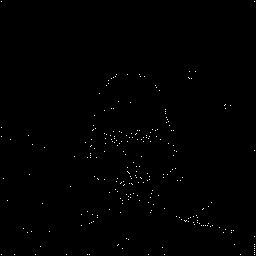

In [51]:
x = Image(filename = image_out_filename)
display(x)

Now we can start with a software-only solution to compare the quality of the outut and the elapsed time 

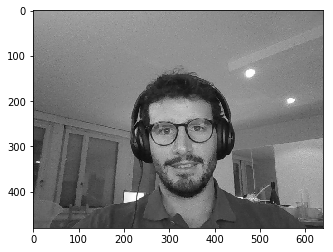

In [52]:
src = cv.imread(image_in_filename)
if src is None:
    print('Could not open or find the image:', input)
    exit(0)
src_gray = cv.cvtColor(src, cv.COLOR_BGR2GRAY)
#src_gray2 = src_gray2[:,:,::-1] 
plt.imshow(src_gray, cmap="gray")
plt.show()

In [53]:
def cornerHarris_demo(val):
    thresh = val
    # Detector parameters
    blockSize = 2
    apertureSize = 3
    k = 0.04
    # Detecting corners
    start_cpu = time.time()
    dst = cv.cornerHarris(src_gray, blockSize, apertureSize, k)
    # Normalizing
    dst_norm = np.empty(dst.shape, dtype=np.float32)
    cv.normalize(dst, dst_norm, alpha=0, beta=255, norm_type=cv.NORM_MINMAX)
    dst_norm_scaled = cv.convertScaleAbs(dst_norm)
    done_cpu = time.time()
    elapsed_cpu = done_cpu - start_cpu
    # Drawing a circle around corners
    circles=0
    for i in range(dst_norm.shape[0]):
        for j in range(dst_norm.shape[1]):
            if int(dst_norm[i,j]) > thresh:
                cv.circle(dst_norm_scaled, (j,i), 5, (0), 2)
                circles = circles+1
    # Showing the result
    print("Points : ", circles)
    plt.imshow(dst_norm_scaled, cmap="gray")
    plt.show()
    return elapsed_cpu

Points :  611


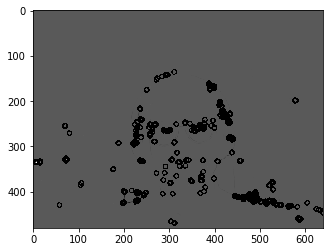

In [54]:
thresh = 77 # initial threshold
elapsed_cpu = cornerHarris_demo(thresh)

In [13]:
print("FPGA time = "+'{0:.10f}'.format(elapsed_fpga)+"\nCPU time  = "+'{0:.10f}'.format(elapsed_cpu))

FPGA time = 0.5115175247
CPU time  = 0.0109274387


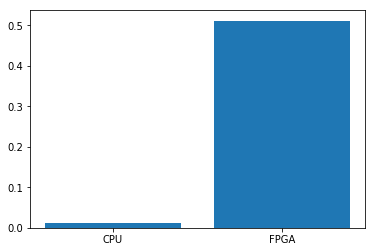

In [14]:
height = [elapsed_cpu, elapsed_fpga]
bars = ('CPU', 'FPGA')
y_pos = np.arange(len(bars))
plt.bar(y_pos, height)
plt.xticks(y_pos, bars)
plt.show()